# New customer interaction strategy for Model Fitness gys chain

One of the most common problems gyms and other services face is customer
churn. How do you know if a customer is no longer with the gym. We can
calculate churn based on people who get rid of their accounts or don't renew
their contracts. However, sometimes it's not obvious that a client has left: they
may walk out on tiptoes.

Churn indicators vary from field to field. If a user buys from an online store
rarely but regularly, you can't say they're a runaway. But if for two weeks they
haven't opened a channel that's updated daily, that's a reason to worry: the
follower might have gotten bored and left.

For a gym, it makes sense to say a customer has left if they don't come for a
month. Of course, it's possible they're in Cancun and will resume their visits
when they return, but's that's not a typical case. Usually, if a customer joins,
comes a few times, then disappears, they're unlikely to come back.

In order to fight churn, Model Fitness digitized a number of customer profiles.
Your task is to analyze them and come up with a customer retention strategy.

In this project we intend to:

- Learn to predict the probability of churn (for the upcoming month) for each customer

- Draw up typical user portraits: select the most outstanding groups and describe their main features

- Analyze the factors that impact churn most

- Draw basic conclusions and develop recommendations on how to improve customer service:

          
          - Identify target groups
          - Suggest measures to cut churn
          - Describe any other patterns you see with respect to interaction with customers

-------------------------------------

In [1]:
#libraries
from pprint import pprint
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter('ignore')
        
#-DA libs
import pandas as pd
import numpy as np

#vis libs
import seaborn as sns
import matplotlib.pyplot as plt

#ML libs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, max_error, mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, accuracy_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV



###  Download the data:

In [2]:
try:
    data = pd.read_csv('/datasets/gym_churn_us.csv')
    
except:
    data =  pd.read_csv('C:/Users/jenya/Desktop/gym_churn_us.csv')
    
data.columns=data.columns.str.lower()

In [3]:
int_columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'age', 'lifetime', 'churn']
data[int_columns] = data[int_columns].astype('uint8')
data[int_columns].dtypes

gender             uint8
near_location      uint8
partner            uint8
promo_friends      uint8
phone              uint8
contract_period    uint8
group_visits       uint8
age                uint8
lifetime           uint8
churn              uint8
dtype: object

In [4]:

print(data.shape)
print('----'*20)
print(data.info())
print('----'*20)
print(data.describe())
print('----'*20)
display(data.head(5))

(4000, 14)
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   uint8  
 1   near_location                      4000 non-null   uint8  
 2   partner                            4000 non-null   uint8  
 3   promo_friends                      4000 non-null   uint8  
 4   phone                              4000 non-null   uint8  
 5   contract_period                    4000 non-null   uint8  
 6   group_visits                       4000 non-null   uint8  
 7   age                                4000 non-null   uint8  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                    

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


**Current dataset fields:**

User data for the preceding month:

- 'Churn' — the fact of churn for the month in question

- 'gender' 

- 'Near_Location' — whether the user lives or works in the neighborhood where the gym is located

- 'Partner' — whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)

- Promo_friends — whether the user originally signed up through a "bring a friend" offer (they used a friend's promo code when paying for their first membership)

- 'Phone' — whether the user provided their phone number

- 'Age'

- 'Lifetime' — the time (in months) since the customer first came to the gym Data from the log of visits and purchases and data on current membership status

- 'Contract_period' — 1 month, 3 months, 6 months, or 1 year

- 'Month_to_end_contract' — the months remaining until the contract expires

- 'Group_visits' — whether the user takes part in group sessions

- 'Avg_class_frequency_total' — average frequency of visits per week over the customer's lifetime

- 'Avg_class_frequency_current_month' — average frequency of visits per week over the preceding month

- 'Avg_additional_charges_total' — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc

**observesions:**

The data consists of 4000 rows and 14 column.
There are no missing values or duplicated values.
majority of the data types are int types and considering the 1/0 ratio its better to simplify the type and optimize the overall memory usage.

- As we can see there are no missing values in the data. most of the data is either 1 or 0, Which exlains the small std value of the columns and gives us a clear understanding of the mean values.

- all the values are in numeric format

- There are 4k individual values

- it aseems that we can continue with our data to the next stage of EDA

### Carry out exploratory data analysis (EDA):

In this stage we intend to:

- Look at the mean feature values in two groups: for those who left (churn) and for those who stayed (use the groupby() method).

- Plot bar histograms and feature distributions for those who left (churn) and those who stayed.

- Build a correlation matrix and display it.

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


We learn from the data that the typical gym client is 29 Y.O, lives or works near the gym, the client has 4.5 month contrant and an he visits the gym 1.8 times a month; he has been doing so for the last 4 months. He spends an extra 147 on the gym and has its phone number in the gym system.   

In [6]:
data.groupby(['churn']).mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


By comapring the means of the two groups,those who left (churn = 1) and for those who stayed, we see how their mean values are similiar in most columns and the only columns that are noticably different are values that are related to duration, such as contact lenght or fequency of gym visits.

for the clients that stayed:

- 87% live/works close to the gym.
- 53% participate in th partner program.
- 35% joined brcause of promotions.
- 46% have group visits.
- average contract period of 5.7 months
- 2 calsses of average per month
- are in the gym for the last 4.7 months.
- spend 158 on average per month.
- 5.2 months until the end of contract


for the clients that left:
- 76% live/work close to the gym
- 35% participate in th partner program.
- 18% joined brcause of promotions.
- 26% have group visits.
- average contract period of 1.7 months
- 1 calss of average per month
- are in the gym for the last month.
- spend 115 on average per month.
- 1.6 months until the end of contract

Next step is to check the ratio of churn/not-churn clients in the data.

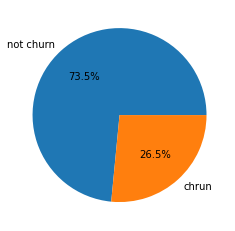

In [7]:
labelz=['not churn','chrun']
plt.pie(data.churn.value_counts(), labels = labelz,autopct='%1.1f%%')
plt.show()

as expected the groups are not equally rpersented in the data and the churn ratio is about 4:1. 

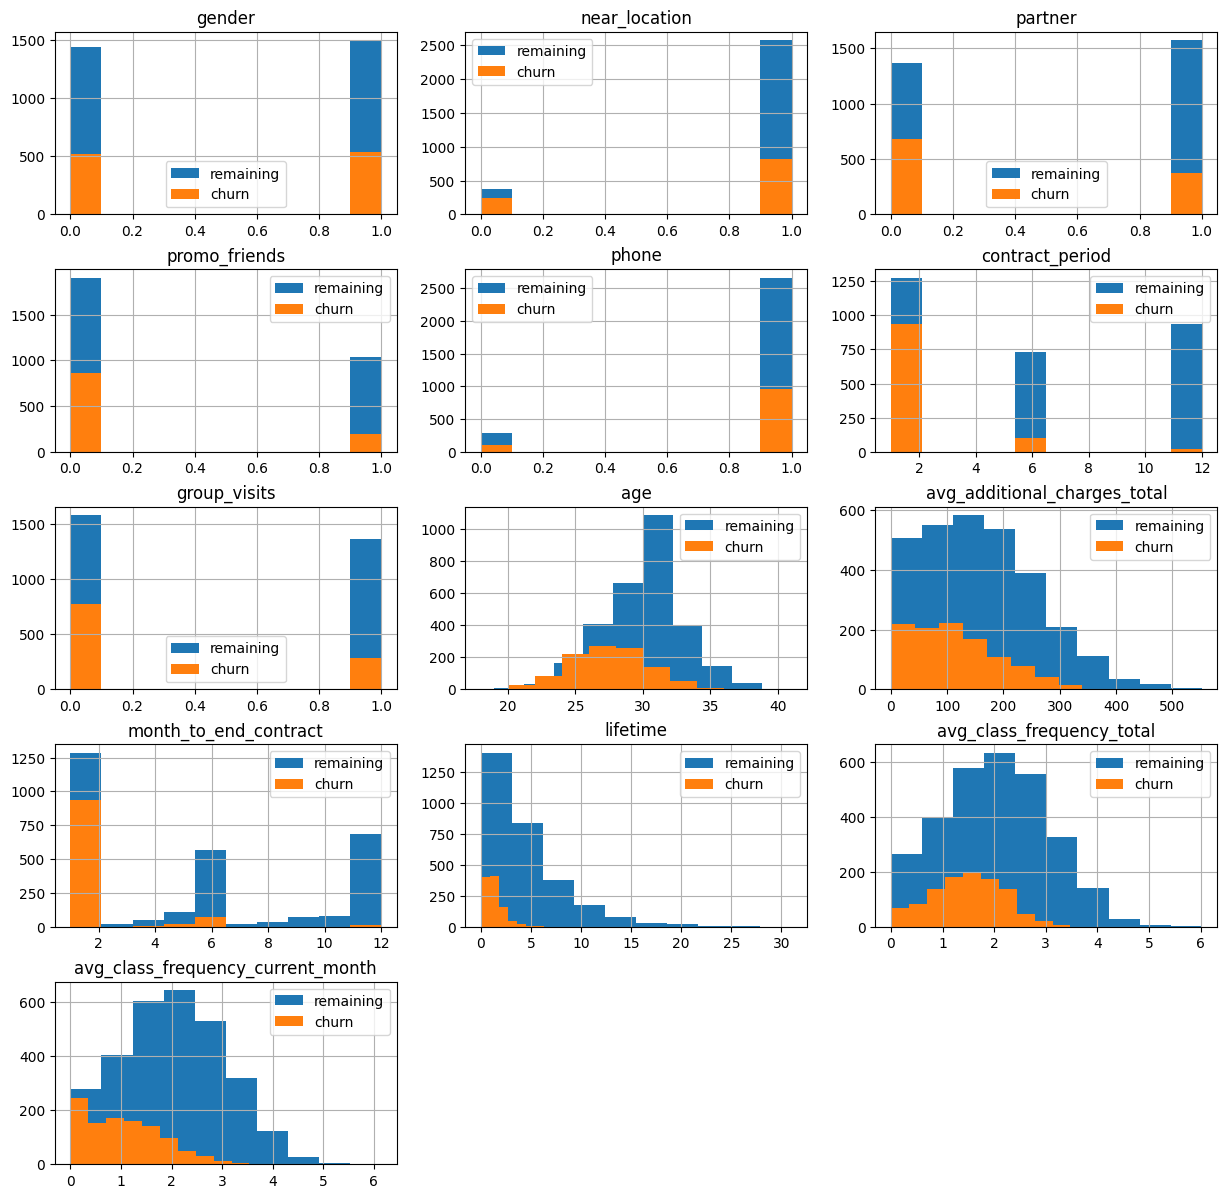

In [8]:
r, c = 5, 3
x_i, y_i = 0, 0

# this time we will examine the sum of all features, grouped by class, where not churn is 0 and churn is 1
fig, axes = plt.subplots(figsize = (15, 15), dpi = 100)

for col in data.drop('churn', axis = 1).columns:
    ax = plt.subplot2grid((r, c), (x_i, y_i))
    ax = data.groupby('churn')[col].hist()
    plt.title(col)
    plt.subplots_adjust(hspace=0.3)
    plt.legend(['remaining', 'churn'])
    y_i += 1
    if y_i == c:
        x_i += 1
        y_i = 0

Overall it seems that the clients who stay with the gym have higher values almost for each feature: living in a near location, being a part of partner program and promo campaign, having more group visits, more additional charges, longer lifetime as client in the gym, and frequency of visits.

Now lets observe the correlations of the features:

<AxesSubplot:>

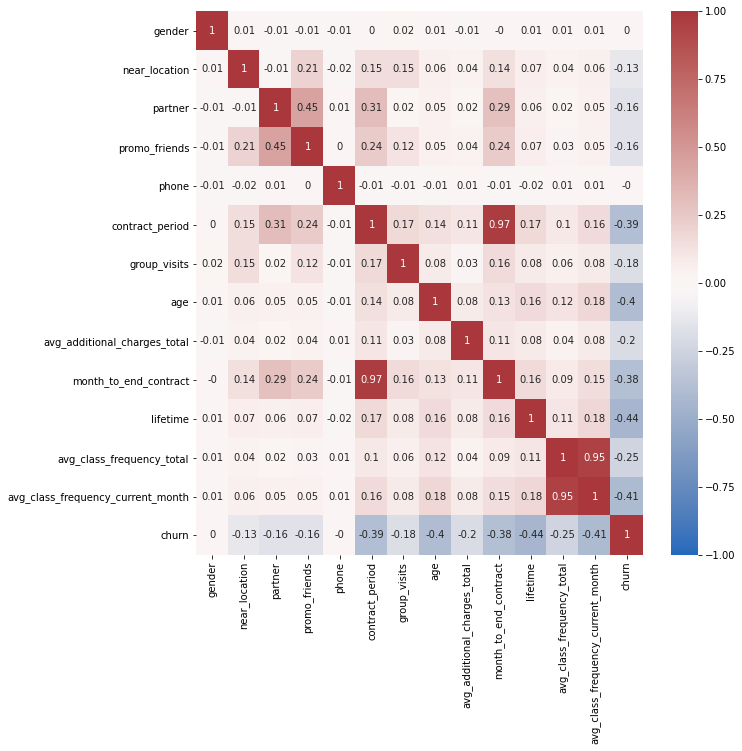

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
matrix = data.corr().round(2)
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')

Theres a negative correlation between Churn and lifetime(-0.44),avg monthly visit(-0.41), age(-0.4) contrat period (-0.39) and month to end contract(-0.38).

Strongest correlation is between month_to_end_contract and contract_period, which makes sense since both column refer to months.

**Observations**

By comapring the means of the two groups,those who left (churn = 1) and for those who stayed, we see how their mean values are similiar in most columns and the only columns that are noticably different are values that are related in sorts to durations of time.

In general, all costumers that left the gym have shorter contract period, are generally younger, spend less on gym services and visited the gym less if comapred to the costumers that stayed.

### Build a model to predict user churn:

For our model to work we need to associate all of our features to two classes: churn / not churn and train the model to guess each class correctly, when it is given a set of features.

We will examine three algorithms: Logistic regression, Random Forest and Gradient Boosting.



**In this stage we intend to:**
- Build a binary classification model for customers where the target feature is the user's leaving next month. 

- Divide the data into train and validation sets using the train_test_split() function.

- Train the model on the train set with two methods:
                                                   
 - Logistic regression
 - Random forest
 - GradientBoostingClassifier

- Evaluate accuracy, precision, and recall for both models using the validation data and Use them to compare the models to see  Which model gave better results

In [10]:
# Set a random state value as constant
RANDOM_STATE = 42

In [11]:
# divide the data into features (the X matrix) and a target variable (y)
X = data.drop('churn',axis=1)
y = data['churn']

In [12]:
X_train_og, X_test, y_train_og, y_test = train_test_split(X, y,test_size = 0.2,random_state = RANDOM_STATE)

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_og,y_train_og,test_size = 0.25,random_state = RANDOM_STATE)

When carrying out a linear regression, keep two things in mind:

- Features should be standardized.

- The linear regression model is prone to overfitting and is unstable when features are mutually correlated.


In [14]:
scaler = StandardScaler()
scaler.fit(X_train)
X_sc_train = scaler.fit_transform(X_train)
X_sc_test = scaler.transform(X_test)
x_sc_valid = scaler.transform(X_valid)

In [15]:
# Fit the chosen model and evaluate error metrics of regression
def evaluate_regression(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('MAE:{:.3f} MSE:{:.3f} R2:{:.3f}'\
          .format(mean_absolute_error(y_test, y_pred), 
          mean_squared_error(y_test, y_pred),
          r2_score(y_test, y_pred)))

In [16]:
# Fit the chosen model and evaluate metrics for classification
def evaluate_classification(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1]
    metrics_dict = {'Accuracy': accuracy_score(y_test, y_pred), 
                    'Precision': precision_score(y_test, y_pred), 
                    'Recall': recall_score(y_test, y_pred),
                    'F1': f1_score(y_test, y_pred),
                    'ROC_AUC': roc_auc_score(y_test, proba)}
 
    display(pd.DataFrame([metrics_dict]).T)
    return metrics_dict

In [17]:
# LogisticRegression
evaluate_regression(m = LogisticRegression(random_state=RANDOM_STATE, solver = 'newton-cg'), X_train = X_train, y_train = y_train,X_test = X_test, y_test = y_test)

MAE:14.691 MSE:0.086 R2:0.543


In order to make sense of the result we need to evaluate the model by more informative metrics, taken from sklearn.metrics library

In [18]:
lr_predictions = evaluate_classification(m = LogisticRegression(
    random_state = RANDOM_STATE, solver = 'newton-cg'), 
    X_train = X_sc_train, y_train = y_train,
    X_test = x_sc_valid, y_test = y_valid)

,0
Accuracy,0.920000
Precision,0.875576
Recall,0.837004
F1,0.855856
ROC_AUC,0.973538


The metrics we got for the logistic regression model are good but we can improve them if we try our data on a random forest model.

The Random Forest Classifier has a lot of hyperparameters that can have an impact on the quality of the predictions of our model. That being said, lets try to find a good score depending on the number of estimators.

In [19]:
score = 0
n_estimators = 1

for i in range(1, 501, 10):
    m = RandomForestClassifier(n_estimators = i, random_state = RANDOM_STATE)
    m.fit(X_train, y_train)
    predictions = m.predict(X_valid)
    score_test = recall_score(y_valid, predictions)
    if score_test > score:
        score = score_test
        n_estimators = i
print(score)
print(n_estimators)

0.8370044052863436
91


In [20]:
# RandomForestClassifier
rf_predictions = evaluate_classification(m = RandomForestClassifier(
    n_estimators = n_estimators, random_state = RANDOM_STATE), 
    X_train = X_sc_train, y_train = y_train,
    X_test = x_sc_valid, y_test = y_valid)

,0
Accuracy,0.912500
Precision,0.855204
Recall,0.832599
F1,0.843750
ROC_AUC,0.970074


In [21]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [22]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=RANDOM_STATE, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.7s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.8s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=6

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [23]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 70,
 'bootstrap': True}

In [24]:
rf_predictions_2 = evaluate_classification(m = RandomForestClassifier(
   n_estimators = rf_random.best_params_['n_estimators'],
   min_samples_split =rf_random.best_params_['min_samples_split'],
   min_samples_leaf=rf_random.best_params_['min_samples_leaf'],
   max_features=rf_random.best_params_['max_features'],
   max_depth=rf_random.best_params_['max_depth'],
   bootstrap=True, 
   random_state=RANDOM_STATE),
   X_train = X_sc_train, y_train = y_train,X_test = x_sc_valid, y_test = y_valid)


,0
Accuracy,0.912500
Precision,0.868545
Recall,0.814978
F1,0.840909
ROC_AUC,0.970628


These are very good metrics but we can try and maximize them with a gradient boosting model and see if the values can improve even more.

In [25]:
# GradientBoostingClassifier
gb_predictions = evaluate_classification(m = GradientBoostingClassifier(
    random_state = RANDOM_STATE),
    X_train = X_sc_train, y_train = y_train,X_test = x_sc_valid, y_test = y_valid)

,0
Accuracy,0.931250
Precision,0.917476
Recall,0.832599
F1,0.872979
ROC_AUC,0.977005


lets make a plot to visually to compare the results of the models

In [26]:
compare_results = pd.DataFrame({'logistic regression': lr_predictions,
                                'random forest': rf_predictions,
                                'random forest v2' : rf_predictions_2,
                                'gradient boosting': gb_predictions
})

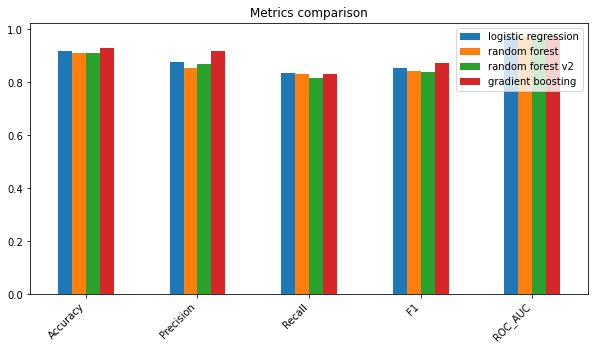

In [27]:
compare_results.plot.bar(figsize = (10, 5))
plt.xticks(rotation = 45, ha = 'right')
plt.title('Metrics comparison')
plt.show()

In [28]:
compare_results.style.highlight_max(axis = 1, color = 'lightgreen')


,logistic regression,random forest,random forest v2,gradient boosting
Accuracy,0.920000,0.912500,0.912500,0.931250
Precision,0.875576,0.855204,0.868545,0.917476
Recall,0.837004,0.832599,0.814978,0.832599
F1,0.855856,0.843750,0.840909,0.872979
ROC_AUC,0.973538,0.970074,0.970628,0.977005


Gradient boosting turned up as the best model for our data.
We can use it to predict the target value.

In [29]:
# Train the model
model = GradientBoostingClassifier(random_state = RANDOM_STATE)
model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

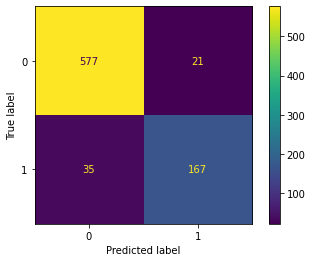

In [30]:
plot_confusion_matrix(model, X_test, y_test) 
plt.show()

In [31]:
y_pred = model.predict(X_valid)
cm_model = confusion_matrix(y_valid, y_pred = y_pred)
tn, fp, fn, tp = cm_model.ravel()
print('True Negatives: ',tn)
print('False Positives: ',fp)
print('False Negatives: ',fn)
print('True Positives: ',tp)

True Negatives:  556
False Positives:  17
False Negatives:  38
True Positives:  189


The model has mistaken in 35 cases of predicting positive outcome (client churned), and in 21 cases of predicting negative (client have not churned).

In [32]:
# Observe feature importances
features = pd.DataFrame(model.feature_importances_) 
features['feature'] = X.columns
features.columns = ['coeff', 'feature']
features = features.reindex(columns = ['feature', 'coeff'])
features.sort_values(by = 'coeff', ascending = False)

,feature,coeff
10,lifetime,0.429339
12,avg_class_frequency_current_month,0.164928
11,avg_class_frequency_total,0.132915
7,age,0.121910
9,month_to_end_contract,0.068864
5,contract_period,0.051527
8,avg_additional_charges_total,0.024122
6,group_visits,0.004685
1,near_location,0.000633
3,promo_friends,0.000523


The most influent feature for positive result (client churned) is lifetime. If all other feature coefficients wouldn't change and together with that the lifetime value would have increased by 1%, than the probability of predicting churn would have changed by 47%. As we remember from the heatmap - lifetime and churn were middle-level correlated as well as other features: monthly and total average visits, age, contract period and months to end contract are at the top of our feature importances table.

### Create user clusters:

Set aside the column with data on churn and identify object (user) clusters:

- Standardize the data.
- Use the linkage() function to build a matrix of distances based on the standardized feature matrix and plot a dendrogram. 
- Train the clustering model with the K-means algorithm and predict customer clusters. (Let the number of clusters be n=5, so that it'll be easier to compare your results with those of other students. However, in real life, no one will give you such hints, so you'll have to decide based on the graph from the previous step.)

- Look at the mean feature values for clusters. Does anything catch your eye?
- Plot distributions of features for the clusters. Do you notice anything?
- Calculate the churn rate for each cluster (use the groupby() method). Do they differ in terms of churn rate? Which clusters are prone to leaving, and which are loyal?

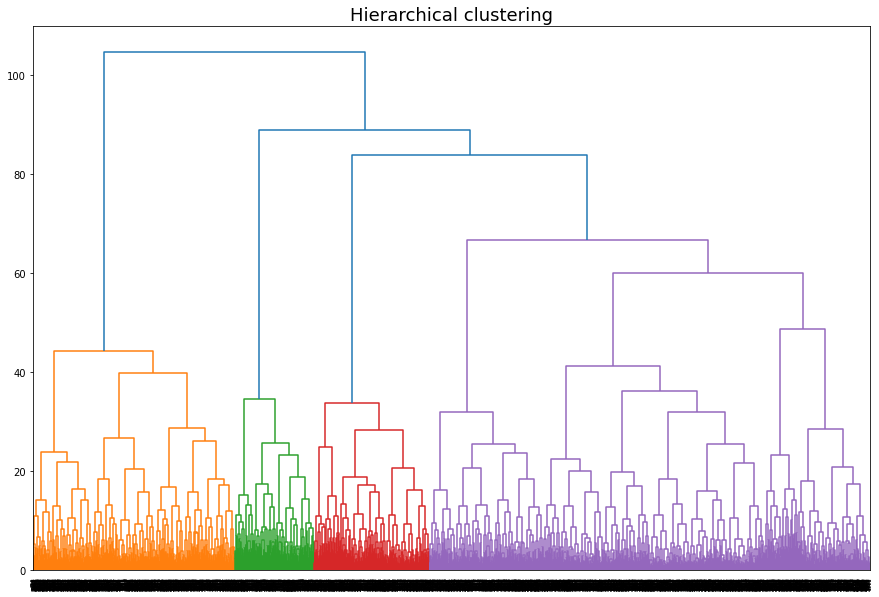

In [33]:
# Standartize the feature matrix 
X_st = scaler.fit_transform(X)
linked = linkage(X_st, method = 'ward')
plt.figure(figsize = (15, 10))
dendrogram(linked, orientation = 'top')
plt.title('Hierarchical clustering', fontsize=18)
plt.show()

- we managed to distinguish between 4 clusters.
- 1 cluster seems to be bigger than the others since the distance between the features ar closer.

In [34]:
km = KMeans(n_clusters = 5, random_state = RANDOM_STATE)
labels = km.fit_predict(X_st)
data['cluster_km'] = labels

In [35]:
data['cluster_km'].value_counts().sort_index()

0     633
1     889
2     865
3    1227
4     386
Name: cluster_km, dtype: int64

In [36]:
data.groupby('cluster_km', as_index = False).mean().T

,0,1,2,3,4
cluster_km,0.000000,1.000000,2.000000,3.000000,4.000000
gender,0.502370,0.554556,0.499422,0.485738,0.523316
near_location,0.949447,0.849269,0.937572,0.718011,0.862694
partner,0.829384,0.263217,0.737572,0.299919,0.471503
promo_friends,0.998420,0.052868,0.478613,0.018745,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,3.097946,2.606299,11.854335,1.914425,4.777202
group_visits,0.448657,0.436445,0.546821,0.276284,0.427461
age,29.104265,30.008999,29.905202,28.083945,29.297927
avg_additional_charges_total,141.774331,159.774265,163.509804,129.496414,144.208179


cluster 0 = In this cluster there are 633 clients, The majority of are in the promotional friend program, 24% of them are clients that left.

cluster 1 = In this cluster there are 889 clients, average age is at 30, only 8% are clients that left.

cluster 2 = In this cluster there are 865 clients, highest average of contract period that stands at 11.8 month and highest additional charges(163), lowest number of clients that left.

cluster 3 = In this cluster there are 1227 clients, lowest contract period and lowest age average, highest churn rate stands at 57%.

cluser 4 = In this cluster there are 386 clients, no phone registered in the system, churn rate of 26%.

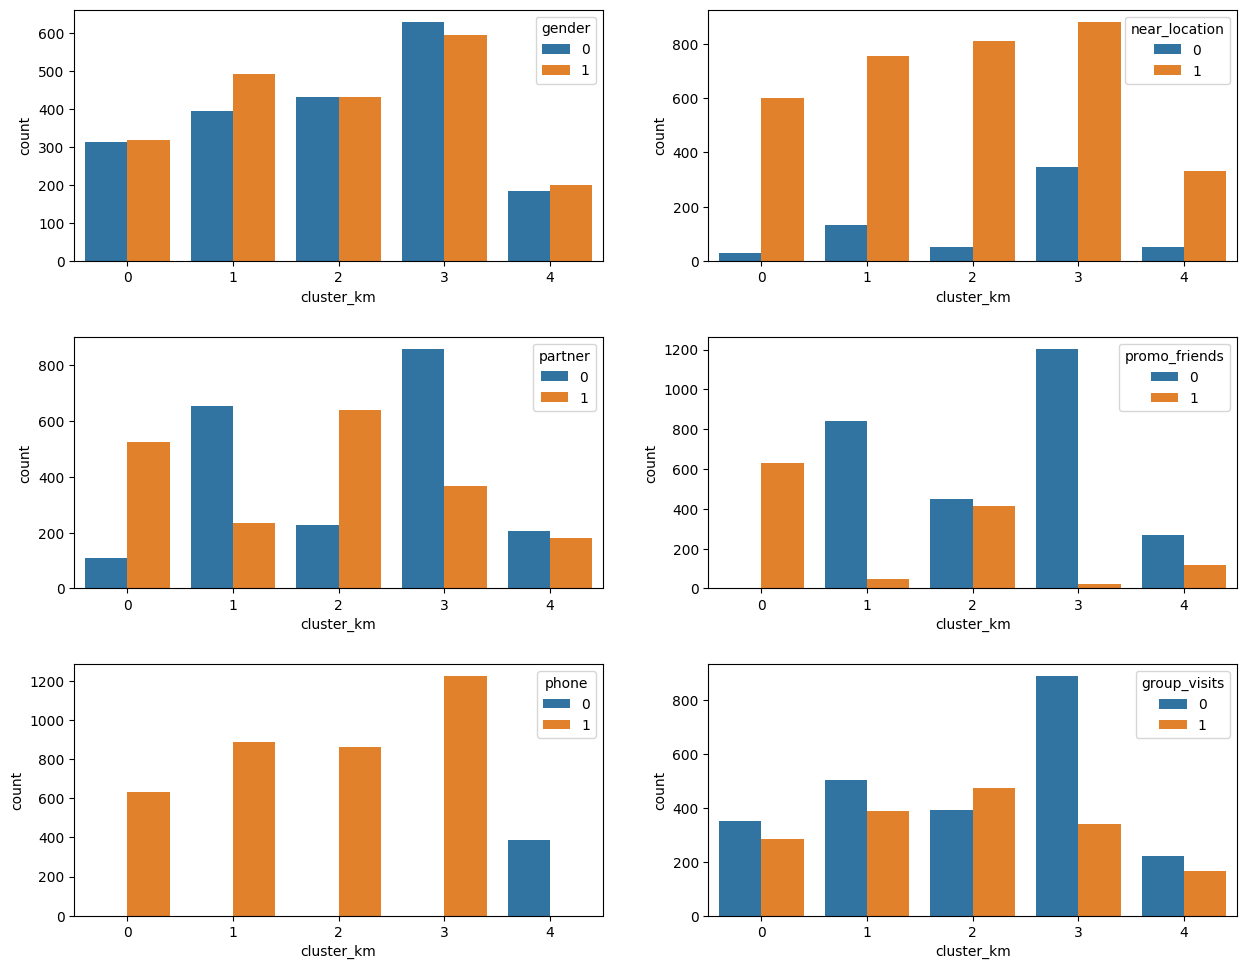

In [37]:
r, c = 3, 2
x_i, y_i = 0, 0
# Draw bar plots for categorical features
fig, axes = plt.subplots(r, c, figsize = (15, 12), dpi = 100)
for i in ['gender', 'near_location', 'partner', 
           'promo_friends', 'phone', 'group_visits']:
    sns.countplot(data = data, x = 'cluster_km', hue = i, ax = axes[x_i, y_i])
    plt.subplots_adjust(hspace = 0.3)
    y_i += 1
    if y_i == c:
        x_i += 1
        y_i = 0

- gender = all clusters seem to have an equal distribution of genders

- near_location = majority of clients in all the clusters live or work near the gym

- partner program = here clusters 0 and 2 are more engaged than clusters 1 and 3. cluster 4 is small but seems to be balanced.

- promo friends = clusters 1 and 3 are the least integrated in the program.

- phone = only cluster 4 doesnt have phone numbers. 

- group visits = all cluster have group visits, clusers 1 and 3 have the least.

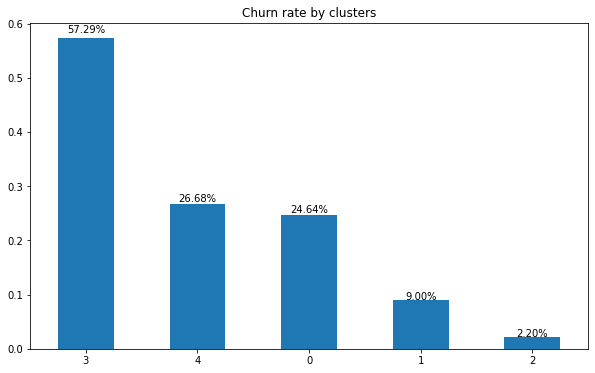

In [38]:
ax = data.groupby('cluster_km', as_index = False)\
    .mean().sort_values(by = 'churn', ascending = False)['churn']\
    .plot.bar(figsize = (10, 6))
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height * 1.02), ha = 'center')
plt.xticks(rotation = 0)
plt.title('Churn rate by clusters')
plt.show()

Each cluster has a differnt churn rate:

- Smallest churn rates are at 2.2% for cluster 2 and 9% for cluster 1, clusters remained almost full since last month.
- Mid range churn rates are at 24-27% for clusters 0 and 4, a quarter of the churns left since last month. 
- Highest churn rate is t 57.3% for cluster 3, this cluster shrunk in more than a half since last month.

 ### conclusions and basic recommendations on working with customers:

The predictive model is based on a GradientBoostingClassifier algorithm implementation.

The features that effect churn feature are lifetime, avg monthly visit, age, contrat period and month to end contract.


for the clients that stayed:
- 87% live/works close to the gym.
- 53% participate in th partner program.
- 35% joined brcause of promotions.
- 46% have group visits.
- average contract period of 5.7 months
- 2 calsses of average per month
- are in the gym for the last 4.7 months.
- spend 158 on average per month.
- 5.2 months until the end of contract

for the clients that left:
- 76% live/work close to the gym
- 35% participate in th partner program.
- 18% joined brcause of promotions.
- 26% have group visits.
- average contract period of 1.7 months
- 1 calss of average per month
- are in the gym for the last month.
- spend 115 on average per month.
- 1.6 months until the end of contract


In [39]:
data.groupby('cluster_km', as_index = False).mean().T

,0,1,2,3,4
cluster_km,0.000000,1.000000,2.000000,3.000000,4.000000
gender,0.502370,0.554556,0.499422,0.485738,0.523316
near_location,0.949447,0.849269,0.937572,0.718011,0.862694
partner,0.829384,0.263217,0.737572,0.299919,0.471503
promo_friends,0.998420,0.052868,0.478613,0.018745,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,3.097946,2.606299,11.854335,1.914425,4.777202
group_visits,0.448657,0.436445,0.546821,0.276284,0.427461
age,29.104265,30.008999,29.905202,28.083945,29.297927
avg_additional_charges_total,141.774331,159.774265,163.509804,129.496414,144.208179


With the help of the K-means algorithm we clustered all our customers into 5 groups and are able to recommend a specialized approach for each group:


Cluster 0

- Churn - 24%
- Live or work near the fitness center
- Most of them are employees of partner companies- 82% 
- Sign up for 3 month contract  
- Most of them attend group classes - in 44% cases
- Most of them came via the promotion campaign - 99%

Clients of this cluster are soon to be churned. They need extra attention and engagement


Cluster 1

- Churn - 8%
- Live or work near fitness center
- Have high average additional charges - 159
- Most frequently visit the gym - 2.7 times on average
- Tend to sign up for contracts NOT for a long period - on average 2.6 months

Those are very good clients as well, but the contract period is short, maybe they need some extra loyalty program


Cluster 2
- Churn - 2%
- Live or work near fitness center
- Have the highest contract period -11 months
- Have the highest average additional charges - 163

Those our best clients - a reward policy would be appropriate for those clients. Everybody loves free shirts and merch!


Cluster 3

- Churn - 57% - the highest
- Live or work near a fitness center
- Mostly 1-3 month short-term membership holders
- Lowest number of visits in total and for month
- Youngest group of average

We should try to revive their interest with a targeted campaign. Maybe offer some exclusive discounts for membership holders 


Cluster 4

- Churn - 26%
- Live or work near a fitness center
- No mobile number
- The average duration of contracts is 4.5 months

An alterntive way of interaction is essential for those clients, such as email or a big announcement board at the gym entrance.